In [1]:
from numpy import arctan, cos, pi, zeros
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, IBMQ, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [2]:
def make_circuit(N, t, measure = True):
    q = QuantumRegister(N+1, 'q')
    c = ClassicalRegister(N+1, 'c')
    circuit = QuantumCircuit(q, c)

    def phi(k):
        if(k == N/3 - 1):
            return arctan(-t)
        return arctan(-t * cos(phi(k+1)))
    
    def make_barrier():
        circuit.barrier(*map(lambda k: q[k], range(0, N+1)))


    # stage 0
    for i in range(0, int(N/3)+1):
        circuit.x(q[3*i])    

    make_barrier()

    # stage 1
    circuit.ry(-2*phi(0), q[1])

    for i in range(1, int(N/3)):
        # todo: define as custom cry gate
        control = q[3*i-2]
        target = q[3*i+1]
        
        circuit.x(control)
        circuit.sx(target)
        circuit.cp(-2*phi(i), control, target)
        circuit.rz(2*phi(i), control)
        circuit.x(control)
        circuit.sxdg(target)

        
    make_barrier()

    # stage 2
    # col 1
    for i in range(0, int(N/3)):
        circuit.cx(q[3*i+1], q[3*i+2])

    # col 2
    for i in range(0, int(N/3)):
        circuit.rz(pi, q[3*i+1])
        circuit.cx(q[3*i+2], q[3*i+3])

    # col 3
    for i in range(0, int(N/3)):
        circuit.cx(q[3*i+1], q[3*i])
        circuit.rz(pi, q[3*i+2])

    # measure all qubits
    if measure:
        make_barrier()
        for i in range(0, N+1):
            circuit.measure(q[i], c[i])

    return circuit

In [3]:
def run_local(circuit):
    backend = QasmSimulator()
    qc_compiled = transpile(circuit, backend)
    job_sim = backend.run(qc_compiled, shots=1024)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc_compiled)
    return counts

In [4]:
def run_ibm(circuit):
    provider = IBMQ.get_provider('ibm-q')
    comp = provider.get_backend('simulator_statevector')
    job = execute(circuit, backend=comp)
    
    job_monitor(job)
    
    result = job.result()
    counts = result.get_counts()

    return counts

In [5]:
def compute_averages_from_counts(counts, n_qubits):
    sums = [0.] * n_qubits;
    total = sum(counts.values())

    for s, count in counts.items():
        for i, b in enumerate(s):
            sums[i] += int(b) * count;
            
    return list(map(lambda a: a/total, sums))

In [6]:
def run_experiment(N, t_trials = 12, t_increment = 0.1, run_on_ibm = False):
    assert(N%3 == 0)
    Z = zeros([t_trials, N+1])

    for i in range(0, t_trials):
        print(f"Running N={N}. trial {i+1}/{t_trials}")
        t = t_increment*(i+1)
        circuit = make_circuit(N, t)

        counts = run_ibm(circuit) if run_on_ibm else run_local(circuit)
        Z[i] = compute_averages_from_counts(counts, N+1)
    
    return Z

In [13]:
def visualize(N, t_trials, t_increment, Z):
    x = range(0, N+2)
    y = list(map(lambda n: t_increment * n, range(0, t_trials+1)))

    fig, ax = plt.subplots(figsize=(10,3))

    # use the same palette as in the paper
    C = [[62, 38, 168], [62, 38, 168], [62, 38, 168], [62, 38, 168], [62, 38, 169], [63, 39, 173], [63, 41, 180], [64, 42, 181], [64, 42, 181], [64, 42, 181], [64, 42, 181], [64, 42, 181], [64, 43, 184], [65, 45, 191], [66, 46, 193], [66, 46, 193], [66, 46, 193], [66, 46, 193], [66, 46, 193], [66, 47, 196], [67, 48, 200], [68, 49, 203], [68, 50, 204], [68, 50, 204], [68, 50, 204], [68, 50, 204], [68, 51, 206], [68, 53, 210], [69, 54, 213], [69, 55, 214], [69, 55, 214], [69, 55, 214], [69, 55, 214], [69, 55, 215], [69, 57, 218], [69, 59, 221], [70, 60, 223], [70, 60, 223], [70, 60, 223], [70, 60, 223], [70, 60, 223], [70, 62, 226], [71, 64, 229], [71, 65, 230], [71, 65, 230], [71, 65, 230], [71, 65, 230], [71, 65, 230], [71, 67, 232], [71, 70, 235], [71, 71, 236], [71, 71, 236], [71, 71, 236], [71, 71, 236], [71, 71, 236], [71, 74, 238], [72, 76, 240], [72, 77, 241], [72, 77, 241], [72, 77, 241], [72, 77, 241], [72, 77, 241], [72, 78, 242], [72, 80, 243], [72, 82, 245], [72, 82, 245], [72, 82, 245], [72, 82, 245], [72, 82, 245], [72, 83, 245], [71, 85, 247], [71, 88, 249], [71, 88, 249], [71, 88, 249], [71, 88, 249], [71, 88, 249], [71, 89, 249], [70, 91, 250], [70, 94, 252], [70, 94, 252], [70, 94, 252], [70, 94, 252], [70, 94, 252], [70, 94, 252], [69, 96, 253], [69, 98, 254], [69, 99, 254], [69, 99, 254], [69, 99, 254], [69, 99, 254], [68, 100, 254], [68, 101, 254], [67, 103, 255], [66, 105, 255], [66, 105, 255], [66, 105, 255], [66, 105, 255], [65, 105, 255], [64, 106, 255], [63, 109, 255], [62, 111, 255], [62, 111, 255], [62, 111, 255], [62, 111, 255], [62, 111, 255], [61, 112, 255], [58, 115, 255], [56, 117, 255], [56, 117, 255], [56, 117, 255], [56, 117, 255], [56, 117, 255], [55, 118, 254], [52, 121, 253], [50, 123, 253], [50, 123, 253], [50, 124, 253], [50, 124, 253], [50, 124, 253], [49, 124, 252], [47, 127, 251], [47, 128, 251], [47, 129, 251], [47, 129, 251], [47, 129, 251], [47, 129, 251], [47, 129, 250], [46, 132, 249], [46, 134, 248], [46, 135, 248], [46, 135, 248], [46, 135, 248], [46, 135, 248], [46, 135, 247], [46, 135, 247], [45, 139, 244], [45, 140, 244], [45, 140, 244], [45, 140, 244], [45, 140, 244], [45, 140, 244], [45, 141, 243], [43, 144, 240], [43, 145, 240], [43, 145, 240], [43, 145, 240], [43, 145, 240], [43, 145, 240], [42, 146, 239], [40, 149, 237], [39, 150, 236], [39, 151, 236], [39, 151, 236], [39, 151, 236], [39, 151, 236], [39, 151, 236], [38, 153, 234], [37, 154, 233], [37, 155, 233], [37, 155, 233], [37, 155, 233], [37, 155, 233], [37, 155, 232], [36, 156, 231], [35, 159, 230], [35, 160, 230], [35, 160, 230], [35, 160, 230], [35, 160, 230], [35, 160, 230], [34, 161, 229], [33, 163, 228], [32, 165, 228], [32, 165, 228], [32, 165, 228], [32, 165, 228], [32, 165, 228], [31, 166, 227], [29, 167, 225], [28, 168, 224], [28, 169, 224], [28, 169, 224], [28, 169, 224], [28, 169, 224], [26, 171, 222], [25, 172, 221], [24, 173, 220], [24, 174, 220], [24, 174, 220], [24, 174, 220], [24, 174, 220], [22, 175, 218], [20, 176, 216], [18, 177, 215], [18, 178, 215], [18, 178, 215], [18, 178, 215], [18, 178, 215], [16, 178, 214], [12, 180, 212], [9, 182, 210], [8, 182, 209], [8, 182, 209], [8, 182, 209], [8, 182, 209], [7, 182, 208], [5, 183, 206], [1, 185, 203], [1, 185, 203], [1, 185, 203], [1, 185, 203], [1, 185, 203], [1, 185, 202], [1, 185, 200], [2, 187, 197], [2, 187, 196], [2, 187, 196], [2, 187, 196], [2, 187, 196], [2, 187, 195], [4, 188, 193], [8, 189, 192], [11, 190, 190], [11, 190, 190], [11, 190, 190], [11, 190, 190], [12, 190, 189], [14, 190, 188], [18, 191, 186], [24, 191, 183], [25, 192, 183], [25, 192, 183], [25, 192, 183], [25, 192, 183], [26, 192, 182], [30, 192, 178], [35, 193, 175], [36, 194, 175], [36, 194, 175], [36, 194, 175], [36, 194, 175], [36, 194, 174], [39, 195, 172], [42, 195, 168], [43, 196, 167], [44, 197, 167], [44, 197, 167], [44, 197, 167], [44, 197, 166], [45, 197, 164], [47, 198, 161], [48, 198, 159], [49, 199, 159], [49, 199, 159], [49, 199, 159], [49, 199, 158], [50, 199, 157], [53, 200, 154], [55, 201, 151], [55, 201, 151], [55, 201, 151], [55, 201, 151], [55, 201, 150], [56, 201, 149], [60, 202, 144], [62, 203, 142], [63, 203, 142], [63, 203, 142], [63, 203, 142], [63, 203, 142], [63, 203, 141], [70, 203, 134], [73, 204, 132], [74, 204, 132], [74, 203, 132], [74, 203, 132], [74, 203, 132], [75, 203, 131], [81, 203, 126], [85, 204, 123], [87, 204, 122], [87, 204, 122], [87, 204, 122], [87, 204, 122], [89, 204, 121], [93, 204, 117], [97, 205, 113], [100, 205, 111], [100, 205, 111], [100, 205, 111], [100, 205, 111], [101, 205, 110], [104, 205, 106], [110, 205, 102], [114, 205, 100], [114, 205, 100], [114, 205, 100], [114, 205, 100], [114, 205, 100], [117, 205, 97], [124, 204, 92], [129, 204, 89], [129, 204, 89], [129, 204, 89], [129, 204, 89], [129, 204, 89], [132, 203, 86], [137, 203, 82], [142, 203, 79], [143, 203, 78], [143, 203, 78], [143, 203, 78], [143, 203, 78], [145, 202, 76], [149, 201, 72], [154, 201, 69], [157, 201, 67], [157, 201, 67], [157, 201, 67], [157, 201, 67], [158, 201, 66], [162, 200, 63], [168, 199, 59], [171, 199, 57], [171, 199, 57], [171, 199, 57], [171, 199, 57], [171, 199, 57], [174, 198, 55], [182, 197, 51], [185, 196, 49], [185, 196, 49], [185, 196, 49], [185, 196, 49], [185, 196, 49], [188, 195, 46], [195, 194, 43], [197, 194, 42], [197, 194, 42], [197, 194, 42], [197, 194, 42], [197, 194, 42], [199, 193, 41], [206, 191, 39], [208, 191, 39], [209, 191, 39], [209, 191, 39], [209, 191, 39], [209, 191, 39], [211, 190, 39], [215, 189, 40], [219, 189, 40], [220, 189, 41], [220, 189, 41], [220, 189, 41], [220, 189, 41], [221, 189, 41], [224, 188, 42], [229, 187, 44], [230, 187, 45], [230, 187, 45], [230, 187, 45], [230, 187, 45], [230, 187, 45], [233, 186, 47], [239, 186, 53], [240, 186, 54], [240, 186, 54], [240, 186, 54], [240, 186, 54], [240, 186, 54], [242, 186, 56], [246, 186, 59], [247, 186, 60], [248, 186, 61], [248, 186, 61], [248, 186, 61], [248, 186, 61], [249, 187, 61], [251, 188, 61], [253, 189, 60], [254, 190, 60], [254, 190, 60], [254, 190, 60], [254, 190, 59], [254, 190, 59], [254, 192, 57], [254, 194, 56], [254, 195, 56], [254, 195, 56], [254, 195, 56], [254, 195, 56], [254, 195, 56], [254, 198, 54], [254, 200, 52], [254, 201, 52], [254, 201, 52], [254, 201, 52], [254, 201, 52], [254, 201, 52], [253, 203, 50], [252, 205, 48], [252, 207, 48], [252, 207, 48], [252, 207, 48], [252, 207, 48], [252, 207, 48], [251, 210, 46], [250, 212, 45], [250, 214, 45], [250, 214, 45], [250, 214, 45], [250, 214, 45], [250, 214, 45], [249, 215, 44], [248, 218, 43], [247, 220, 42], [247, 220, 42], [247, 220, 42], [247, 220, 42], [247, 220, 42], [247, 222, 41], [246, 224, 40], [245, 227, 39], [245, 227, 39], [245, 227, 39], [245, 227, 39], [245, 227, 39], [245, 228, 38], [245, 230, 37], [245, 233, 36], [245, 233, 36], [245, 233, 36], [245, 233, 36], [245, 233, 36], [245, 234, 35], [245, 236, 33], [246, 238, 32], [246, 239, 32], [246, 239, 32], [246, 239, 32], [246, 239, 32], [246, 240, 31], [246, 241, 30], [247, 243, 28], [247, 245, 27], [247, 245, 27], [247, 245, 27], [247, 245, 27], [247, 245, 26], [248, 247, 25], [248, 249, 23], [249, 251, 21], [249, 251, 21], [249, 251, 21], [249, 251, 21], [249, 251, 21]]
    cmap = colors.ListedColormap(list(map(lambda c: [c[0]/255, c[1]/255, c[2]/255], C)))

    pc = ax.pcolormesh(x, y, Z, cmap=cmap, edgecolors=(0, 0, 0, 0.3), linewidths=.01)

    fig.colorbar(pc)
    fig.suptitle('N = ' + str(N), fontsize=20)
    
    ax.set_xlabel('k', fontsize=18)
    ax.set_ylabel('t', fontsize=18)

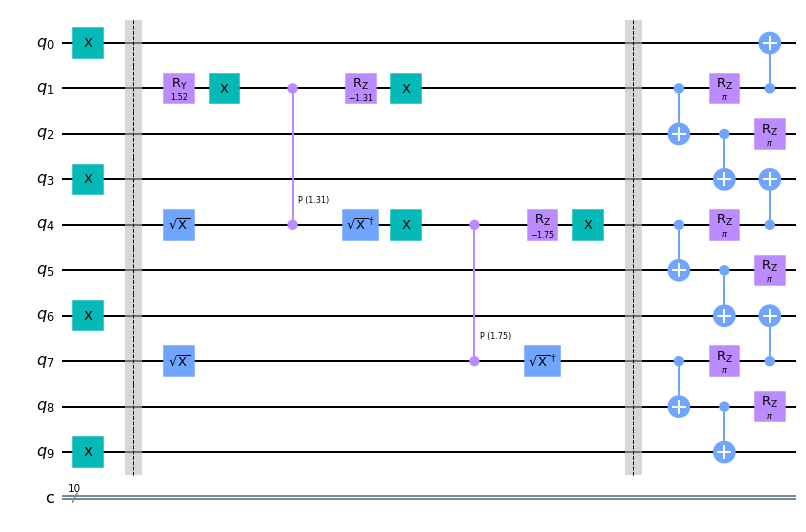

In [8]:
# see what the circuit looks like

circuit = make_circuit(9, 1.2, measure=False)
circuit.draw(output='mpl')

In [9]:
# IBMQ.save_account("token")
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [12]:
N = 24
t_trials = 12
t_increment = 0.1
Z = run_experiment(N, t_trials, t_increment, run_on_ibm=True)

Running N=24. trial 1/12
Job Status: job has successfully run
Running N=24. trial 2/12
Job Status: job has successfully run
Running N=24. trial 3/12
Job Status: job has successfully run
Running N=24. trial 4/12
Job Status: job has successfully run
Running N=24. trial 5/12
Job Status: job has successfully run
Running N=24. trial 6/12
Job Status: job has successfully run
Running N=24. trial 7/12
Job Status: job has successfully run
Running N=24. trial 8/12
Job Status: job has successfully run
Running N=24. trial 9/12
Job Status: job has successfully run
Running N=24. trial 10/12
Job Status: job has successfully run
Running N=24. trial 11/12
Job Status: job has successfully run
Running N=24. trial 12/12
Job Status: job has successfully run


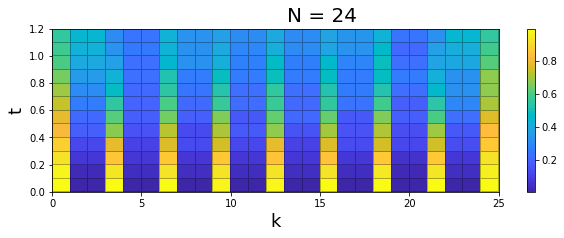

In [14]:
visualize(N, t_trials, t_increment, Z)